In [ ]:
!pip install datasets
!pip install -U transformers
!pip install transformers peft torch
!pip install --upgrade peft
# gym
!pip install gymnasium
!pip install omegaconf

In [ ]:
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

import os
import shutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
import pandas as pd
from torchvision import transforms
import glob
from tqdm import tqdm
from urllib.request import urlopen
from PIL import Image
import json
import collections

from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
import pandas as pd
from datasets import Dataset
import torch.distributions as dist

import time

from sklearn.model_selection import train_test_split

from datasets import load_dataset
from transformers import DataCollatorForSeq2Seq

In [ ]:
!pip show mujoco
!pip install --upgrade gymnasium[mujoco]

import gymnasium as gym

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 22.9 MB/s eta 0:00:00


# **Random seed 고정**

In [ ]:
import random

seed = 40
deterministic = True

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
if deterministic:
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
warnings.filterwarnings('ignore')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **model lora 적용 , 경량화**

In [ ]:
from peft import LoraConfig, get_peft_model

In [ ]:
# LoRA 설정
lora_config = LoraConfig(
    r=16,  # Low-rank 업데이트 행렬 차원
    lora_alpha=16,  # 스케일링 팩터
    lora_dropout=0.1,  # 드롭아웃 비율
    target_modules=["q_proj", "k_proj", "v_proj", "out_proj"],  # QLoRA가 적용될 대상 모듈
)

pretrained model 다운로드

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: fineGrained).
The token `token` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate wh

In [ ]:
from peft import LoraConfig, get_peft_model

# 모델 및 토크나이저 로드
model_name = "meta-llama/Llama-3.2-1B-Instruct"
base_model = AutoModelForCausalLM.from_pretrained(model_name,
                                                  device_map="auto",             # GPU와 CPU를 자동 분배
                                                  torch_dtype="auto",            # 자동으로 적절한 데이터 타입(FP32, FP16 등) 선택
                                                  offload_folder="./offload",    # 메모리가 부족할 경우 CPU로 데이터를 오프로드
                                                  offload_state_dict=True)        # 가중치도 필요 시 CPU로 오프로드

#기존 model freeze
for param in base_model.parameters():
    param.requires_grad = False

model = get_peft_model(base_model, lora_config)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model.resize_token_embeddings(len(tokenizer))

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(128257, 2048)

dataset 정의

In [ ]:
columns = ["state", "action", "reward", "next_state", "done"]
df = pd.DataFrame(columns = columns)

# **data collecting by rl exploration**

In [ ]:
# OpenAI Gym 환경
env = gym.make('HalfCheetah-v4', render_mode = 'rgb_array')

jacobian

In [ ]:
def compute_log_prob(mean, log_std, action_raw):
    # Gaussian 로그 확률 계산
    std = log_std.exp()
    gaussian_log_prob = -0.5 * (((action_raw - mean) / std) ** 2 + 2 * log_std + torch.log(torch.tensor(2 * torch.pi)))
    gaussian_log_prob = gaussian_log_prob.sum(axis=-1)  # 차원 합산

    # Tanh 변환 보정 계산
    log_det_jacobian = torch.log(1 - torch.tanh(action_raw) ** 2 + 1e-6).sum(axis=-1)

    # 최종 로그 확률
    log_prob = gaussian_log_prob - log_det_jacobian
    return log_prob

config

In [ ]:
AC_config = OmegaConf.create({
    "buffer_limit": int(1e6),
    # RL parameter
    'gamma': 0.99,
    'batch_size': 512,

    # neural network parameters
    'device': 'cpu',
    'hidden_dim': 128,
    'state_dim': env.observation_space.shape[0],
    'action_dim': int(env.action_space.shape[0]), # cannot use .n because not actions are continuous!

    # learning parameters
    'lr_actor': 0.0003,
})

replay buffer

In [ ]:
class ReplayBuffer():
    def __init__(self, config):
        self.config = config
        self.buffer = collections.deque(maxlen=self.config.buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, next_s_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, next_s, done = transition
            s_lst.append(s.tolist())
            a_lst.append(a.tolist())
            r_lst.append([r])
            next_s_lst.append(next_s.tolist())
            done_mask = 0.0 if done else 1.0
            done_mask_lst.append([done_mask])

        return torch.Tensor(s_lst), torch.Tensor(a_lst), torch.Tensor(r_lst), \
               torch.Tensor(next_s_lst), torch.Tensor(done_mask_lst)

    def size(self):
        return len(self.buffer)

network build

In [ ]:
class Agent(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config
    self.tanh = nn.Tanh()
    self.relu = nn.ReLU()

    self.actor = nn.Sequential(
        nn.Linear(config.state_dim , config.hidden_dim),
        nn.ReLU(),
        nn.Linear(config.hidden_dim , config.action_dim + config.action_dim))

    self.critic = nn.Sequential(
        nn.Linear(config.state_dim + config.action_dim , config.hidden_dim),
        nn.ReLU(),
        nn.Linear(config.hidden_dim , 1)
    )

    self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=config.lr_actor)
    self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=config.lr_actor)

  def update(self):

    self.actor_optimizer.zero_grad()
    self.critic_optimizer.zero_grad()

    states, actions , rewards , next_states, dones = memory.sample(AC_config.batch_size)

    #critic network
    input = torch.cat([states,actions],axis=1)
    next_input = torch.cat([next_states,actions],axis=1)

    critic = self.critic(input)
    next_critic = self.critic(next_input)

    #loss 계산
    actor_loss = -self.critic(input)
    critic_loss = (self.critic(input) - (rewards+AC_config.gamma*(1-dones)*(self.critic(next_input) - self.critic(input))))**2

    actor_loss = actor_loss.mean()
    critic_loss = critic_loss.mean()

    actor_loss.backward(retain_graph = True)
    critic_loss.backward(retain_graph = True)

    self.actor_optimizer.step()
    self.critic_optimizer.step()

# Trainer loop

In [ ]:
agent = Agent(AC_config)

  0%|          | 0/20 [00:00<?, ?it/s]

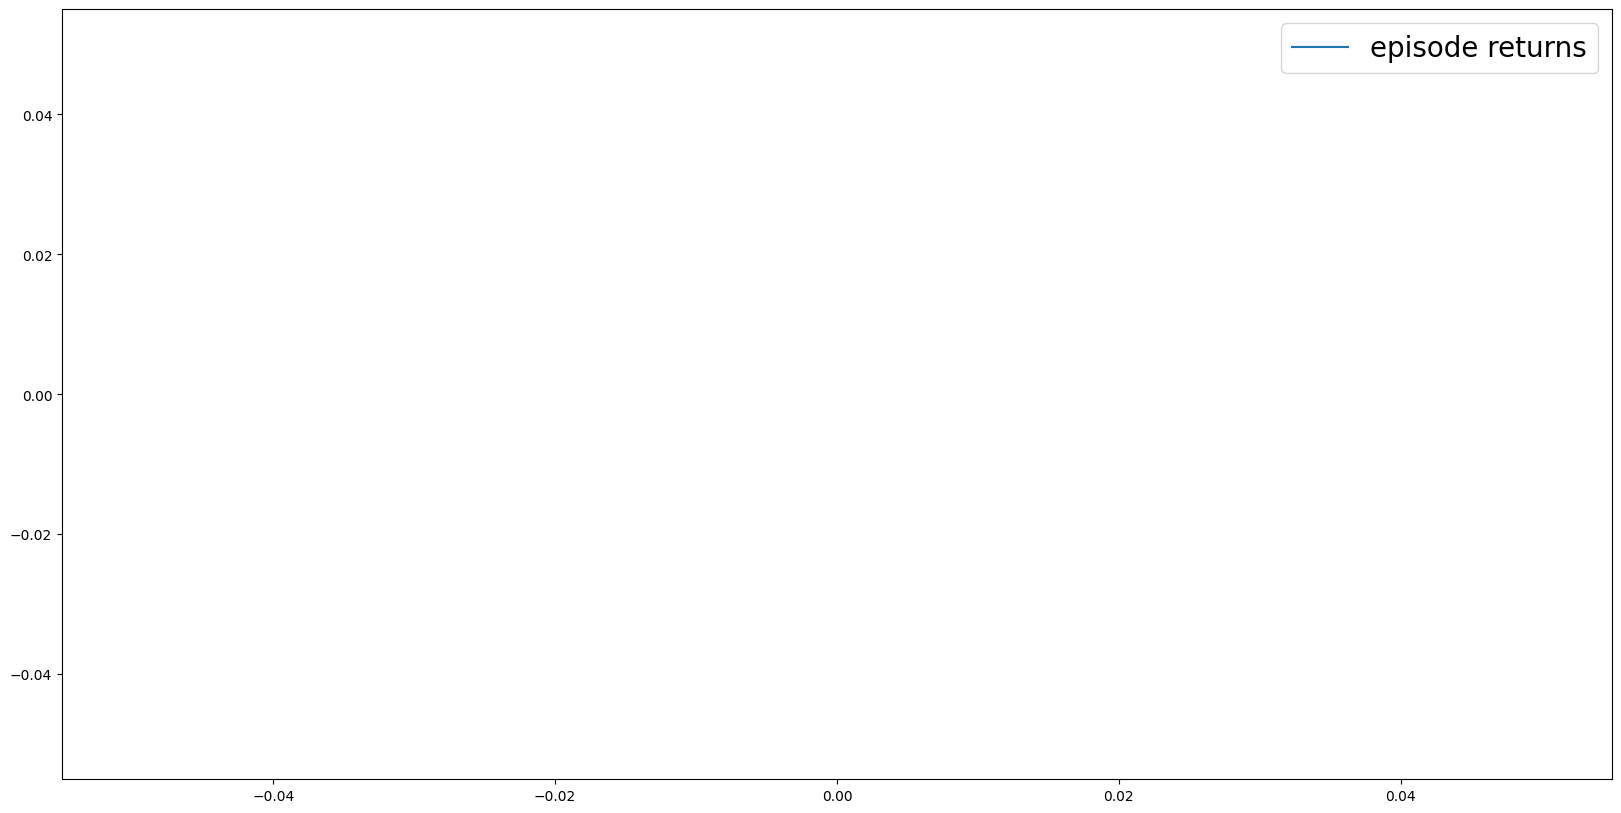

 10%|█         | 2/20 [00:21<03:41, 12.32s/it]

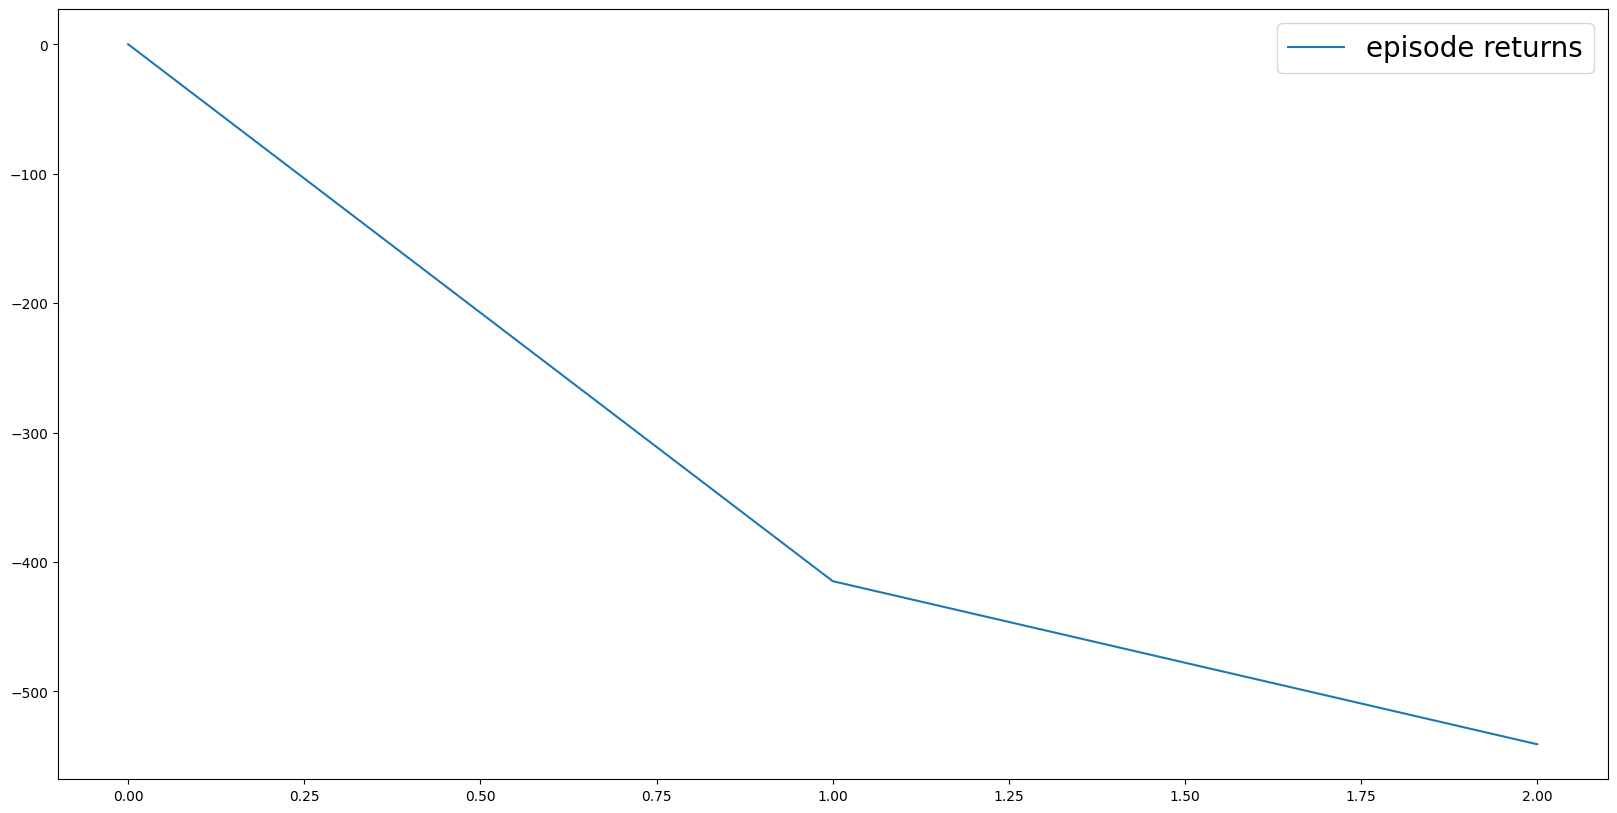

 20%|██        | 4/20 [01:00<04:34, 17.19s/it]

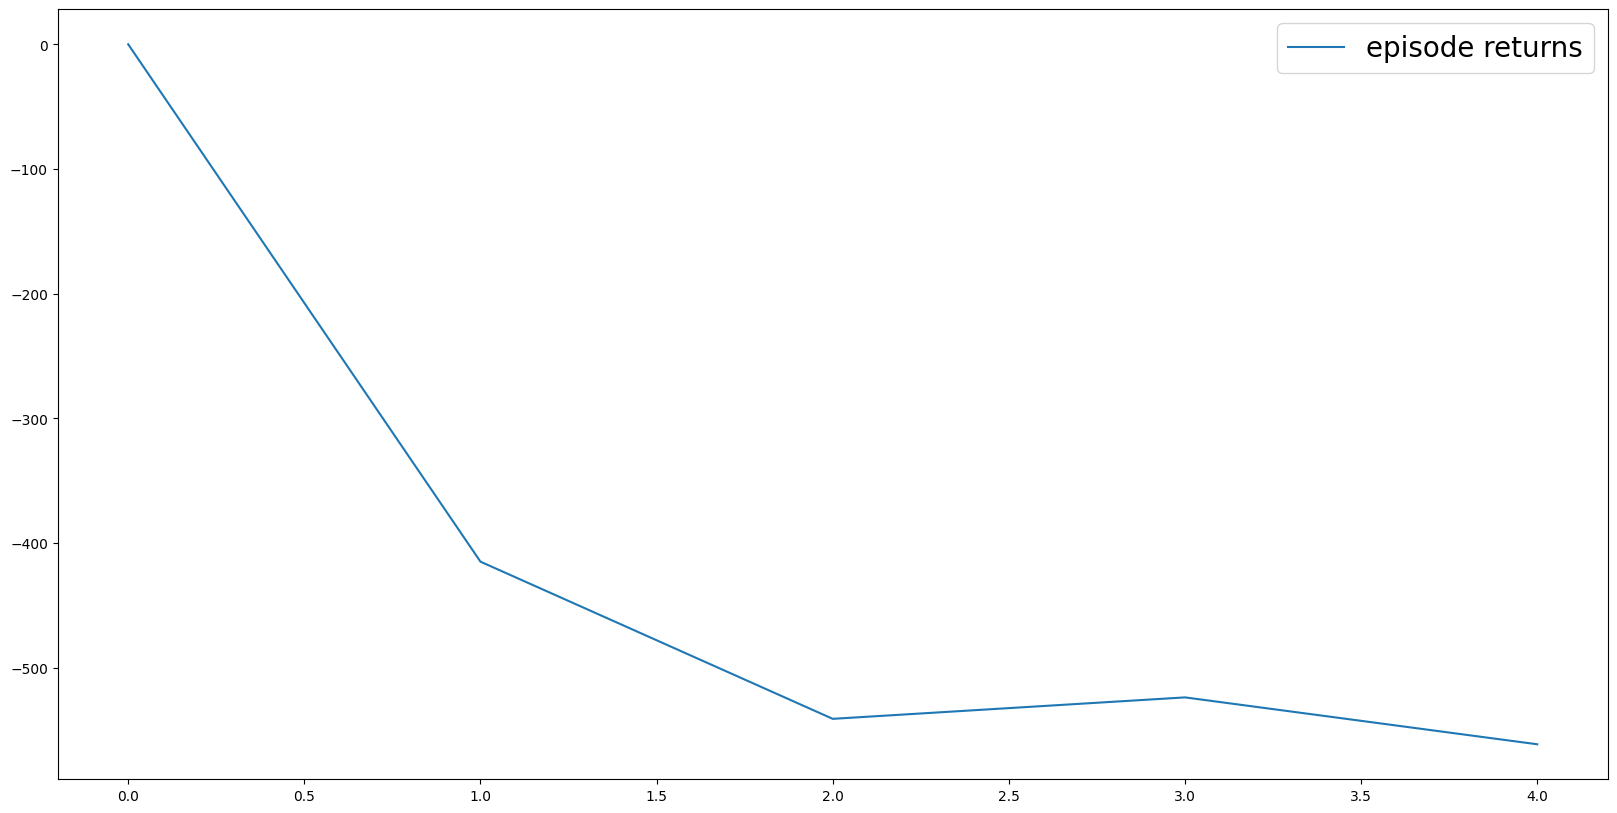

 30%|███       | 6/20 [01:41<04:24, 18.92s/it]

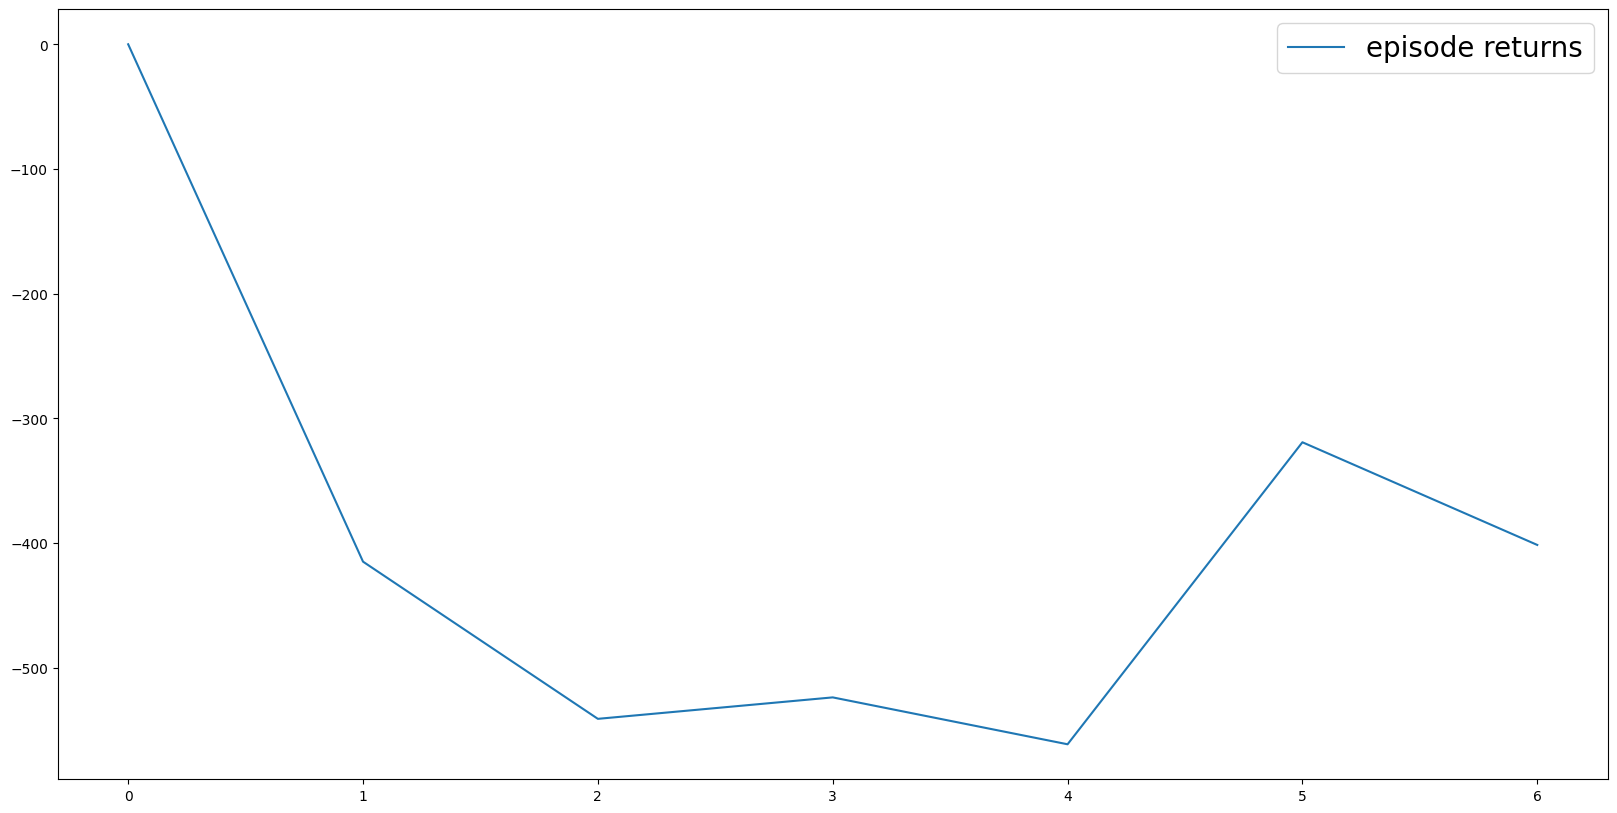

 40%|████      | 8/20 [02:21<03:56, 19.73s/it]

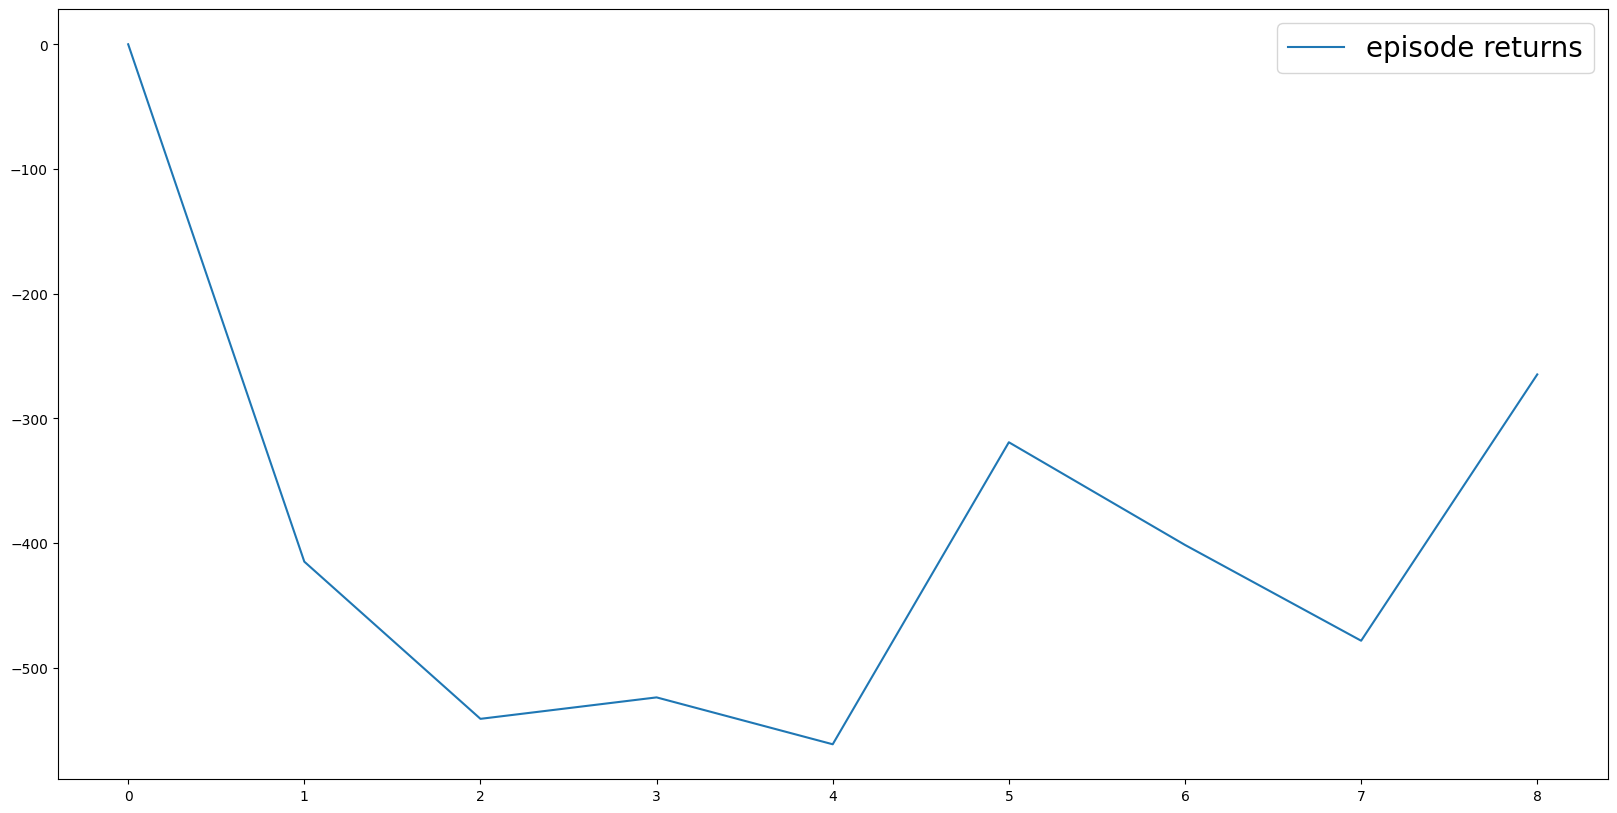

 50%|█████     | 10/20 [03:06<03:29, 20.99s/it]

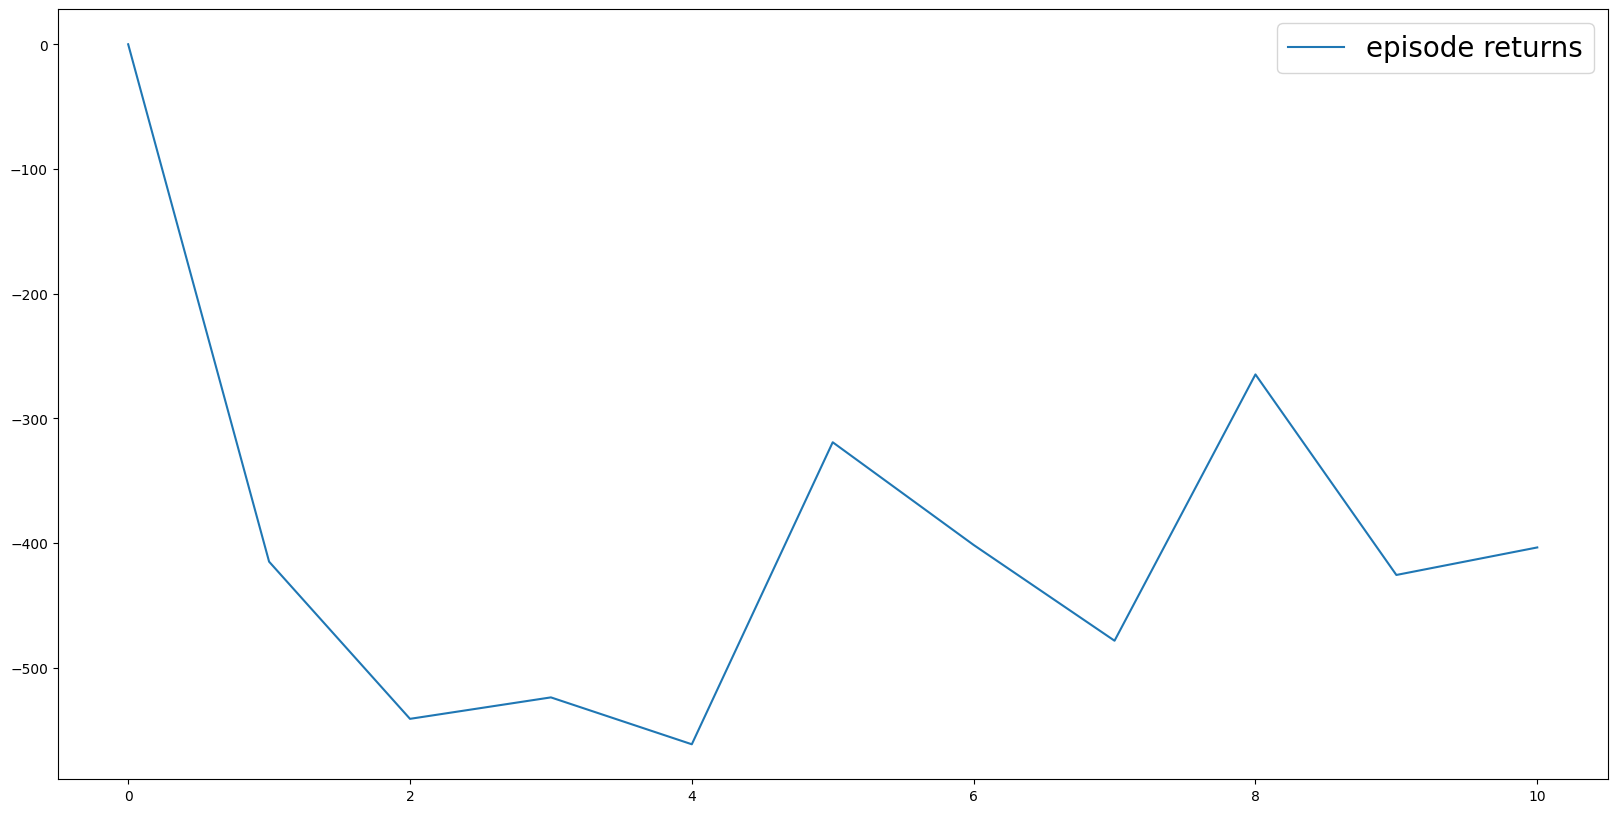

 60%|██████    | 12/20 [03:50<02:53, 21.67s/it]

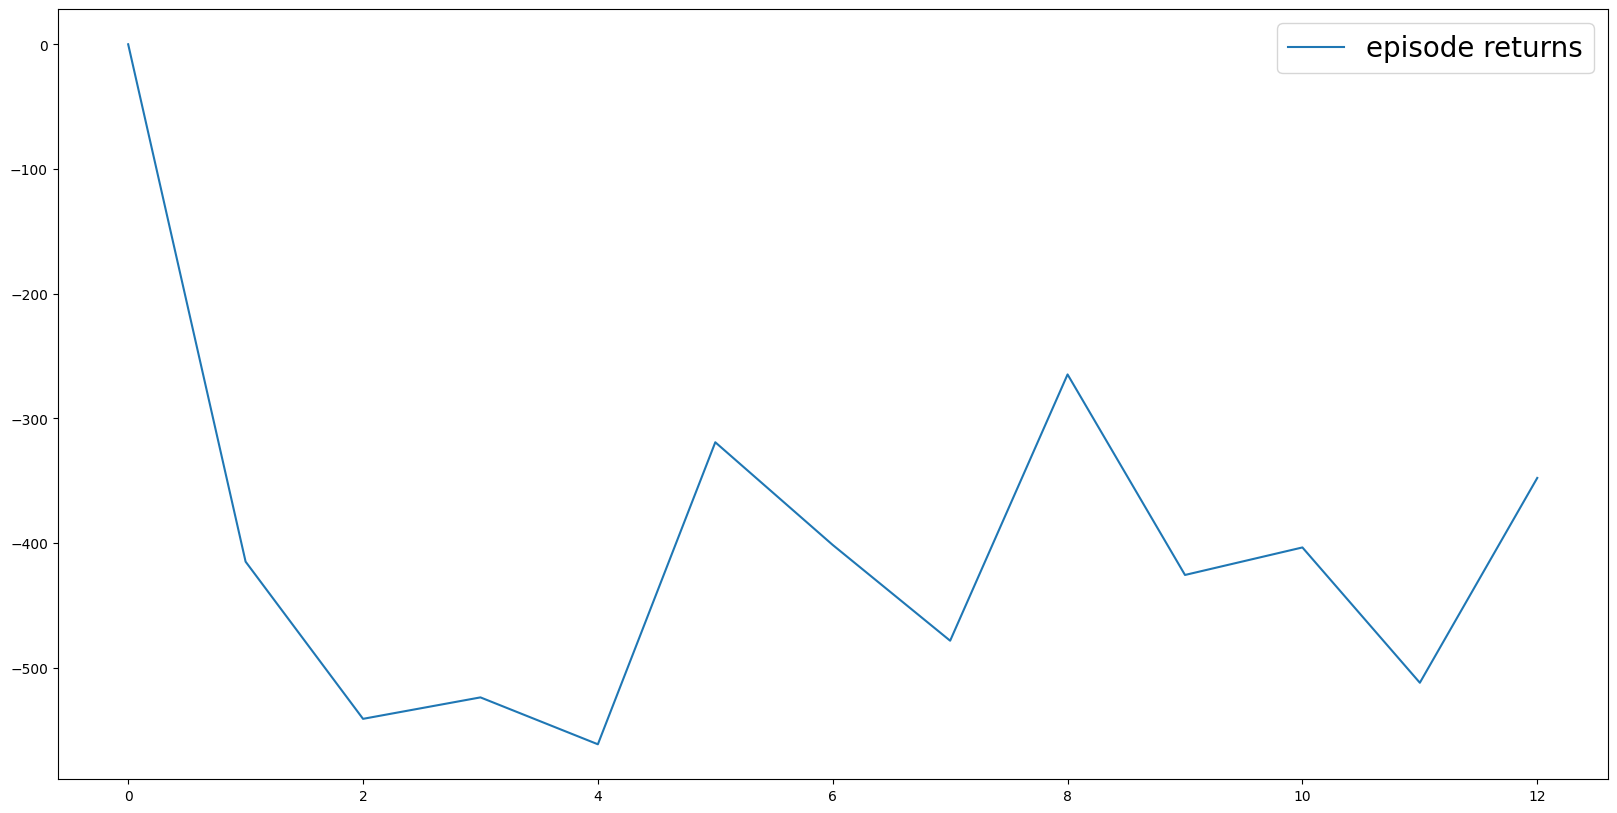

 70%|███████   | 14/20 [04:36<02:13, 22.28s/it]

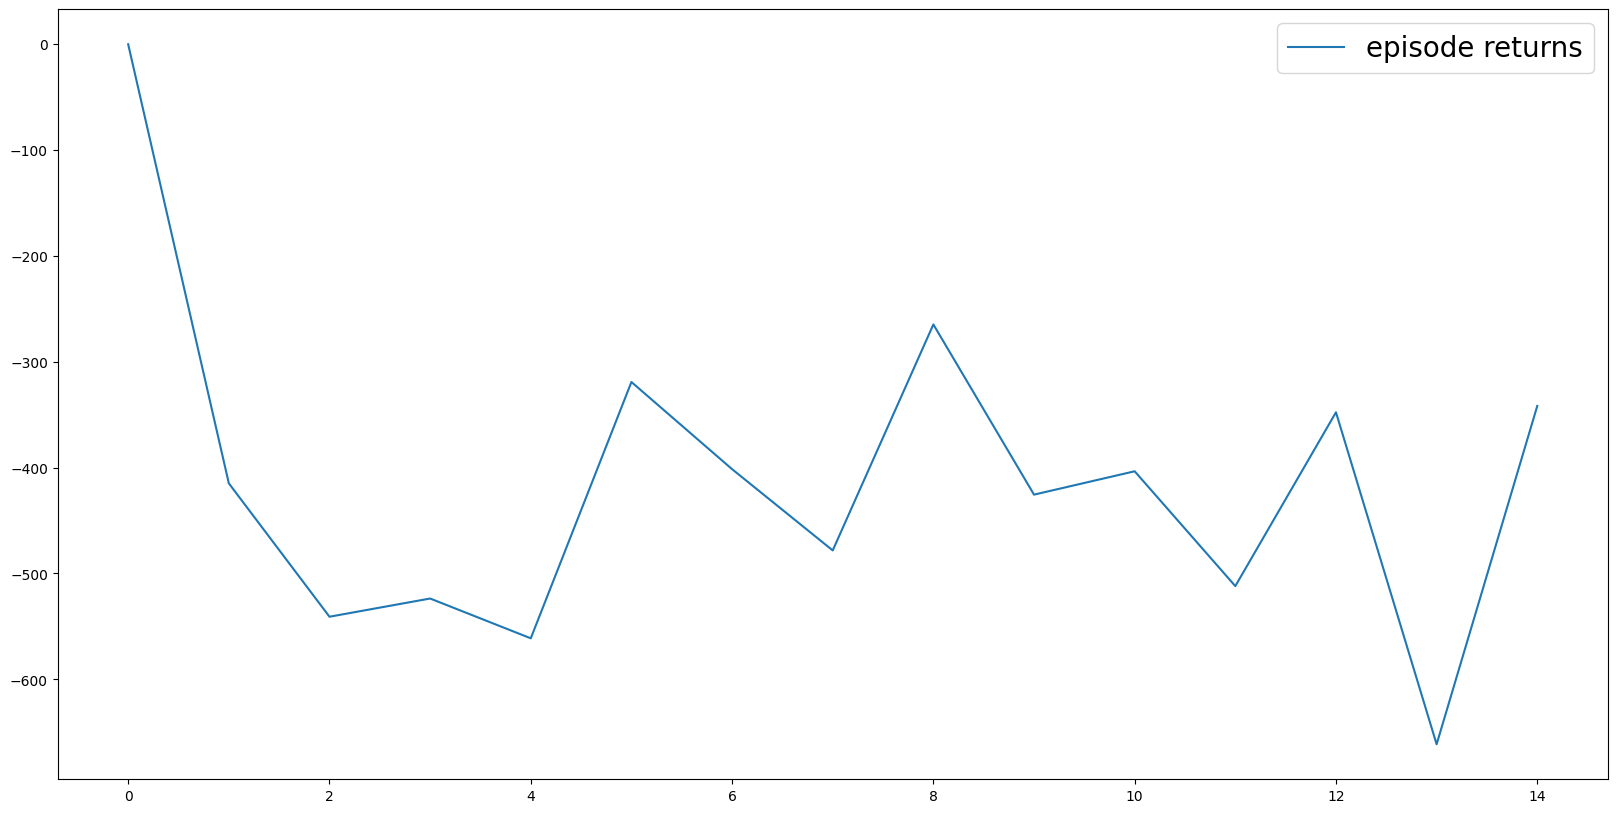

 80%|████████  | 16/20 [05:22<01:30, 22.63s/it]

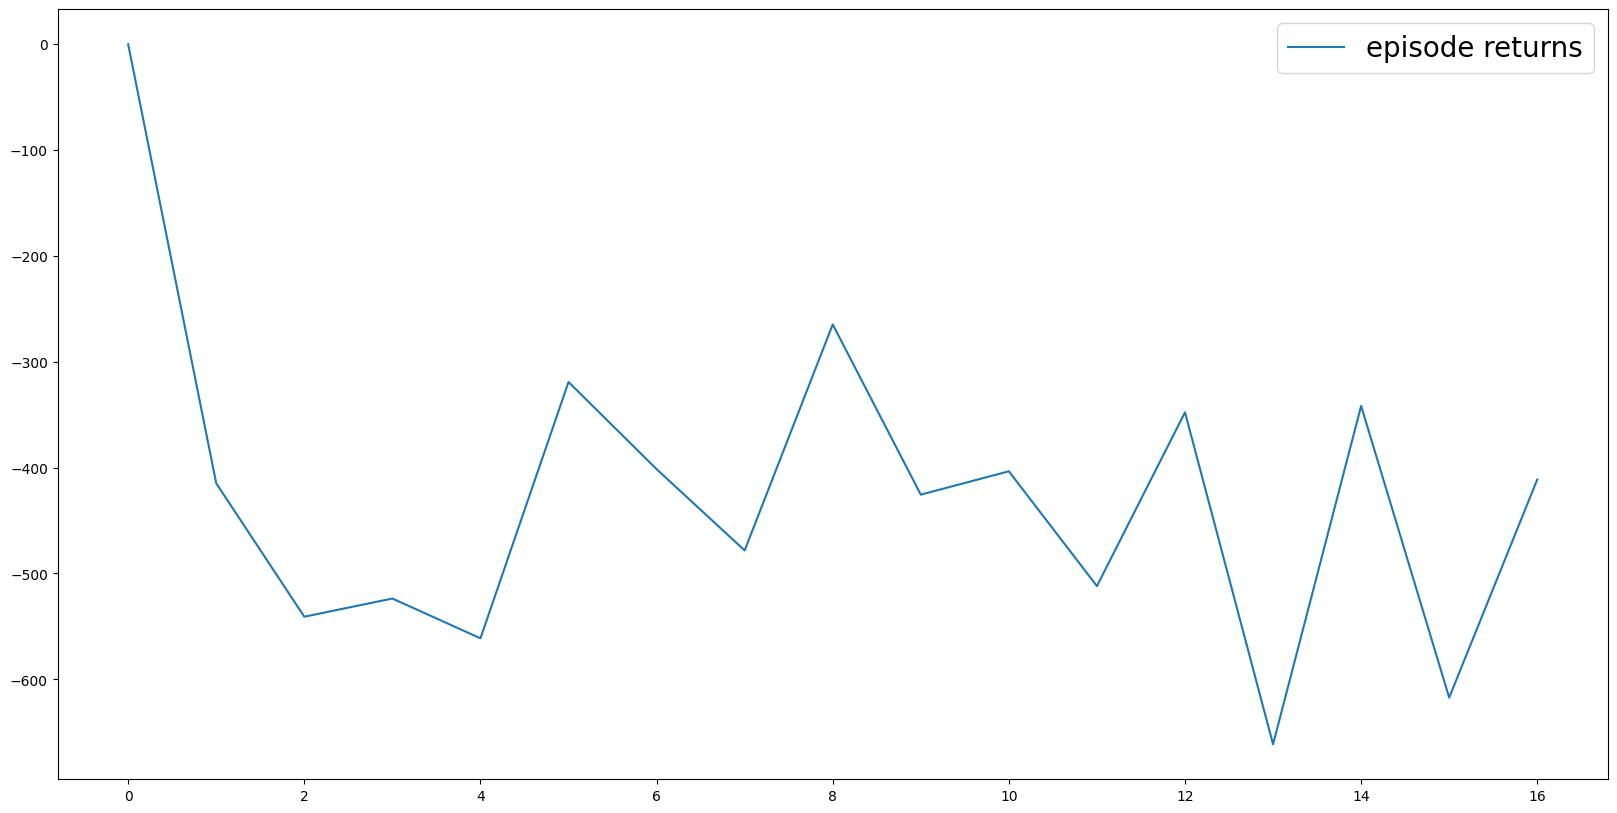

 90%|█████████ | 18/20 [06:09<00:46, 23.10s/it]

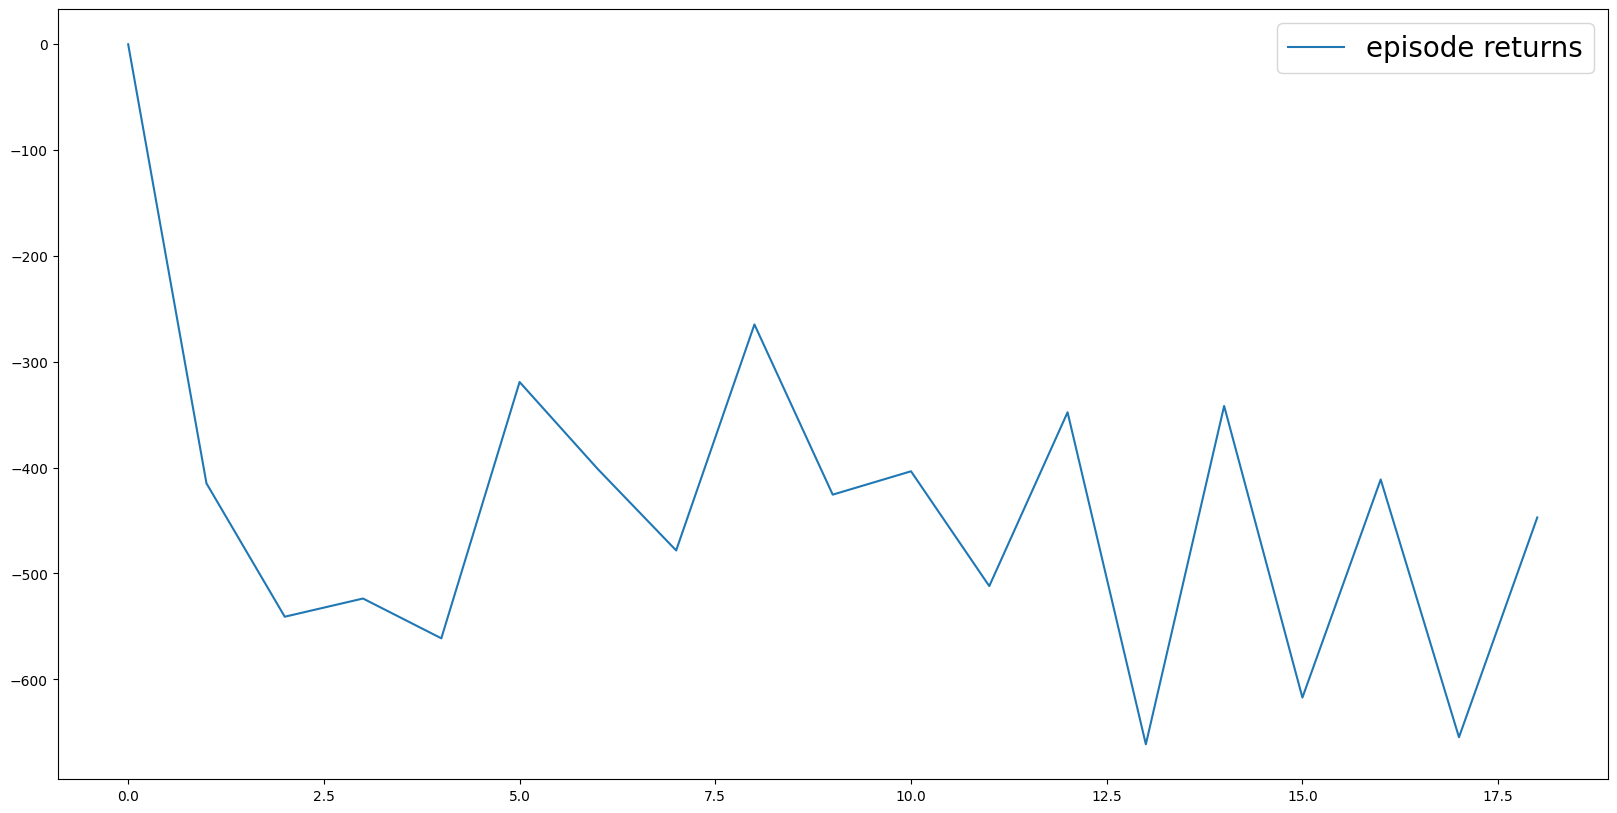

100%|██████████| 20/20 [06:56<00:00, 20.81s/it]


In [ ]:
num_epis, epi_rews = 20, []
memory = ReplayBuffer(AC_config)
tanh = nn.Tanh()

for n_epi in tqdm(range(num_epis)):
  state, _ = env.reset()
  terminated, truncated = False, False
  epi_rew = 0
  cnt = 0

  while not (terminated or truncated):
    cnt += 1
    state = torch.Tensor(state)

    #actor network
    a = agent.actor(state)

    if len(a.shape) >= 2:
      mean = a[:,:6]
      std = a[:,6:]
    else:
      mean = a[:6]
      std = a[6:]

    std = torch.clamp(std,min=1e-10)
    log_std = torch.log(std)
    #don't use jacobian
    normal = dist.Normal(mean , std)
    z = normal.rsample() #reparameterization trick
    z = torch.Tensor(z)

    log_prob = compute_log_prob(mean, log_std, z)

    action = tanh(z)
    policy = log_prob

    # 환경에서 다음 상태 및 보상 얻기
    action = action.detach().numpy()
    next_state, reward, terminated, truncated, _ = env.step(action)
    next_state = torch.Tensor(next_state)

    ### 데이터 저장
    # transition 데이터 한 행으로 저장
    transition = {
        "state": state.tolist(),        # state를 리스트로 변환
        "action": action.tolist(),      # action도 리스트로 변환
        "reward": reward,               # scalar 값
        "next_state": next_state.tolist(),
        "done": terminated or truncated                    # boolean 값
    }

    # DataFrame에 추가
    df = pd.concat([df, pd.DataFrame([transition])], ignore_index=True)
    ###

    if len(agent.actor(next_state).shape) >= 2:
      next_mean = agent.actor(next_state)[:,:6]
      next_std = agent.actor(next_state)[:,6:]
    else:
      next_mean = agent.actor(next_state)[:6]
      next_std = agent.actor(next_state)[6:]

    next_std = torch.clamp(next_std,min=1e-10)
    next_log_std = torch.log(next_std)
    #don't use jacobian
    next_normal = dist.Normal(next_mean , next_std)
    next_z = next_normal.rsample() #reparameterization trick
    next_z = torch.Tensor(next_z)

    next_log_prob = compute_log_prob(next_mean, next_log_std, next_z)

    next_action = tanh(next_z)
    next_policy = next_log_prob

    memory.put([state, action , reward , next_state, terminated or truncated])

    if memory.size() > 1000:
      for i in range(2):
        agent.update()

        epi_rew += reward

        state = next_state

  epi_rews += [epi_rew]

  if n_epi % 2 == 0:
    plt.figure(figsize=(20, 10))
    plt.plot(epi_rews, label='episode returns')
    plt.legend(fontsize=20)
    plt.show()
    plt.close()

# **llm fine tuning**

In [ ]:
#결측값 처리
df = df.fillna(0)
df_train = df.replace(0, "training is not done")

data 구조 설계

["state", "action", "reward", "next_state", "done"]

In [ ]:
input_column = ["state","action","next_state","done"]
label_column = ["reward"]

# 각 행(row)에 대해 지정된 문장을 생성하고 리스트에 저장
train_data = [
    {   "role" : "user" ,
        "content": ",".join([f"{col} : {row[col]}" for col in df_train[input_column]]),
        "label": f"label : {row[label_column]}"
    }
    for _, row in df_train.iterrows()
]

# 특수부호 제거
train_data = [
    {key: value.replace("\n", "").replace("\\", "") if isinstance(value, str) else value
     for key, value in item.items()}
    for item in train_data
]

데이터의 최대 **길이**

In [ ]:
max_data_length = max(len(item["content"]) for item in train_data)
print(max_data_length)

max_label_length = max(len(item["label"]) for item in train_data)
print(max_label_length)

925
52


In [ ]:
def replace_padding_with_ignore(labels, padding_value=128001, ignore_value=-100):
    """
    라벨에서 지정된 패딩 값을 -100으로 변환합니다.
    """
    return [ignore_value if token == padding_value else token for token in labels]

# input_ids, attention_mask, labels 생성
tokenized_data = [
    {
        **tokenizer(
            f"{item['role']} , {item['content']}",
            padding='max_length',
            truncation=True,
            max_length=max_label_length
        ),
        'labels': replace_padding_with_ignore(
            tokenizer(
                item['label'],
                padding='max_length',
                truncation=True,
                max_length=max_label_length
            )['input_ids']
        )
    }
    for item in train_data
]

# 결과 확인
print(tokenized_data[:1])  # 앞의 두 개만 출력

[{'input_ids': [128000, 882, 1174, 1614, 551, 510, 15, 13, 27311, 20502, 17574, 24425, 10617, 1627, 11, 482, 15, 13, 8504, 19852, 24626, 25388, 11123, 26026, 20, 11, 220, 15, 13, 11194, 26008, 25594, 19270, 21776, 21138, 11, 220, 15, 13, 13837, 9565, 24837, 21848, 18017, 6365, 11, 482, 15, 13, 13837, 20691, 14245], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [128000, 1530, 551, 11565, 256, 482, 15, 13, 15901, 11702, 678, 25, 220, 15, 11, 13534, 25, 1665, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256, 128256]}]


Lora 훈련

fp16=True , gradient_accumulation_steps = 16

In [ ]:
# 훈련 설정
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    per_device_train_batch_size=1,
    num_train_epochs=2,
    logging_dir='./logs',
    logging_steps=10,
    fp16=True,
    gradient_accumulation_steps=32,
    learning_rate=1e-5,
)

In [ ]:
# Trainer 설정 및 훈련 시작
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data,
)

train

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
10,15.909200
20,15.790200
30,15.640000
40,15.462600
50,15.237500
60,14.988900
70,14.704600
80,14.375200
90,14.021600
100,13.634100


KeyboardInterrupt: 

# **###Reinforcement learning again with fine tuned model###**

fine tuned llm train with rl method

In [ ]:
model_optimizer = torch.optim.Adam(model.parameters(), lr=AC_config.lr_actor)

In [ ]:
num_epis, epi_rews = 2000, []
memory = ReplayBuffer(AC_config)

for n_epi in tqdm(range(num_epis)):

  model_optimizer.zero_grad()

  state, _ = env.reset()
  terminated, truncated = False, False
  done = terminated or truncated
  epi_rew = 0
  cnt = -1
  while not (terminated or truncated):
    cnt += 1
    state = torch.Tensor(state)

    #state -> df
    second_df = pd.DataFrame(columns = columns)

    ### 데이터 저장
    # transition 데이터 한 행으로 저장
    transition = {
        "state": state.tolist(),        # state를 리스트로 변환
    }

    # DataFrame에 추가
    second_df = pd.concat([second_df, pd.DataFrame([transition])], ignore_index=True)

    #결측값 처리
    second_df = second_df.fillna(0)
    second_df = second_df.replace(0, "training is not done")

    # 각 행(row)에 대해 지정된 문장을 생성하고 리스트에 저장
    second_df = [
        {   "role" : "user" ,
            "content": "output appropriate 6 actions and one value that determines 6 actions. " + ",".join([f"'state' : {second_df['state']}."]),
        }
        for _, row in second_df.iterrows()
    ]


    ###

    # state -> appropriate prompt
    prompts = tokenizer(second_df , return_tensors="pt")

    output = model.generate(**prompts)
    print(output)

    next_state, reward, terminated, truncated, _ = env.step(action.detach().numpy())
    next_state = torch.Tensor(next_state)

    # next_state -> appropriate prompt
    next_prompt = ...

    #next_action
    next_action , _ = model(next_state)

    memory.put([state, action , next_action , reward , next_state, terminated or truncated , cnt])

    if memory.size() > 1000:
      for i in range(2):

        # randomly sample from replay buffer
        states, actions, next_actions, rewards , next_states, dones, time = memory.sample(AC_config.batch_size)

        # states -> appropriate prompts
        prompts = ...

        _ , policies = model(states)

        model_loss = ...

        model_loss = model_loss.mean()

        model_loss.backward(retain_graph=True)

        model_optimizer.step()

        epi_rew += reward

        state = next_state

  epi_rews += [epi_rew]

  if n_epi % 2 == 0:
    plt.figure(figsize=(20, 10))
    plt.plot(epi_rews, label='episode returns')
    plt.legend(fontsize=20)
    plt.show()
    plt.close()

  0%|          | 0/2000 [00:00<?, ?it/s]


ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [ ]:
import os
os.environ['MUJOCO_GL']='egl'
env = gym.wrappers.RecordVideo(env, video_folder='./videos')

In [ ]:
state,_ = env.reset()
terminated, truncated = False, False
for i in range(1):
    while not (terminated or truncated):
      state = torch.Tensor(state)
      ###
      action , policy = model(state)


      action = action.detach().numpy()
      next_state, reward, terminated, truncated, _ = env.step(action)

      state = next_state

env.close()

In [ ]:
from IPython.display import Video
Video("./videos/rl-video-episode-0.mp4", embed=True)